In [220]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

df_train = pd.read_csv("politicES_phase_2_train_public.csv", on_bad_lines='skip')

df_train.drop(['label'], axis=1, inplace=True) 
indices_aleatorios = random.sample(range(len(df_train)), 6000)
df_train = df_train.iloc[indices_aleatorios]

In [221]:
df_train['tweet'] = df_train.apply(lambda row: row['gender'] + " " + row['profession']+ " " + row['ideology_binary']+ " " + row['tweet'], axis=1)
df_train.drop(['ideology_binary','gender','profession'], axis=1, inplace=True) 

In [222]:
df_train

,ideology_multiclass,tweet
20757,moderate_right,male journalist right No hay nada más antidemo...
125202,moderate_right,"male journalist right Objetivo, destruir el «C..."
78746,moderate_left,male journalist left . Cualquier ocasión es bu...
38956,left,female journalist left Dejo esto por aquí. Por...
33499,left,female politician left Cuidado con que las muj...
...,...,...
68413,moderate_right,male journalist right @user El Ministerio de D...
79482,moderate_right,male journalist right @user Las campañas munic...
161370,moderate_left,female journalist left Aunque las unidades de ...
134752,moderate_left,male journalist left La CEOE podría llamarse a...


##  Clasificador

In [223]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, generation, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import tensorflow as tf
from datasets import Dataset
import tqdm as notebook_tqdm

model_name = 'AIDA-UPM/BERTuit-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4, from_tf=True)


All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


In [224]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_train['ideology_multiclass'] = label_encoder.fit_transform(df_train['ideology_multiclass'])

In [225]:
df_train['tweet'] = df_train['tweet'].apply(lambda x: x.replace("@user", "<usr>"))

In [226]:
def tokenize_function(example):
    return tokenizer(example['tweet'])

huggingface_dataset = Dataset.from_pandas(df_train)
huggingface_dataset

Dataset({
    features: ['ideology_multiclass', 'tweet', '__index_level_0__'],
    num_rows: 6000
})

In [218]:
# # Función para tokenizar el dataset
# def tokenize_function(example):
#     return tokenizer(example['gender'], 
#                       example['profession'],
#                       example['ideology_binary'], 
#                       example['tweet'],
                    
#                       )

# # Conversión del DataFrame de pandas a un Dataset de Hugging Face para pasarlo al modelo
# huggingface_dataset = Dataset.from_pandas(df_train)
# huggingface_dataset

In [227]:
# Aplicamos la tokenización a todo el dataset
tokenized_dataset = huggingface_dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map: 100%|██████████| 6000/6000 [00:00<00:00, 16585.63 examples/s]


Dataset({
    features: ['ideology_multiclass', 'tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 6000
})

In [228]:
tokenized_dataset = tokenized_dataset.rename_column("ideology_multiclass", "labels") 
tokenized_dataset = tokenized_dataset.remove_columns(["tweet","__index_level_0__"])  # Nos quedamos solo con los valores que necesita el modelo
tokenized_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 6000
})

In [229]:
# # We can pass multiple strings into the tokenizer and pad them as we need
# model_inputs = tokenizer(["female", "politician","moderate_right","right",
#                           "female politician left Hemos alcanzado el máximo histórico en la tasa de graduación en ESO (84% de los alumnos). ✅ Mejoramos el nivel educativo en España. ✅ Mayor transición hacia las etapas postobligatorias. ✅ Reducimos el abandono temprano.",
#                          ],
#                          return_tensors="pt",
#                          padding=True,
#                          )
# print("Pad token:", tokenizer.pad_token)
# print("Pad token id:" , tokenizer.pad_token_id)
# print("Padding:")
# print(model_inputs)

In [230]:
from datasets import DatasetDict

# Dividimos los datos en entrenamiento y validación. Dejamos un 30% del dataset para validación y test
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
# test_valid_split = train_test_split['test'].train_test_split(test_size=0.66) # Dividimos entre conjunto de validación y test

# Creamos un DatasetDict para organizar los subconjuntos
final_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test'],
     
})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # Introducimos el data collator para trabajar con padding dinámico


 16%|█▌        | 93/600 [05:00<27:37,  3.27s/it]

{'loss': 0.8667, 'learning_rate': 1.69e-05, 'epoch': 0.31}


/Users/juan/miniconda3/envs/master/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 93/600 [05:54<27:37,  3.27s/it]

{'eval_loss': 0.622002124786377, 'eval_accuracy': 0.6841666666666667, 'eval_f1': 0.5566204047914085, 'eval_precision': 0.46989718105543793, 'eval_recall': 0.6841666666666667, 'eval_runtime': 54.2925, 'eval_samples_per_second': 22.102, 'eval_steps_per_second': 1.381, 'epoch': 0.31}


 31%|███       | 186/600 [10:50<21:44,  3.15s/it] 

{'loss': 0.6257, 'learning_rate': 1.38e-05, 'epoch': 0.62}


/Users/juan/miniconda3/envs/master/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 186/600 [11:44<21:44,  3.15s/it]

{'eval_loss': 0.5984419584274292, 'eval_accuracy': 0.6883333333333334, 'eval_f1': 0.571551316920622, 'eval_precision': 0.6061508960358414, 'eval_recall': 0.6883333333333334, 'eval_runtime': 54.0914, 'eval_samples_per_second': 22.185, 'eval_steps_per_second': 1.387, 'epoch': 0.62}


 46%|████▋     | 279/600 [16:39<14:08,  2.64s/it]  

{'loss': 0.5884, 'learning_rate': 1.0700000000000001e-05, 'epoch': 0.93}



 46%|████▋     | 279/600 [17:31<14:08,  2.64s/it]

{'eval_loss': 0.5608683228492737, 'eval_accuracy': 0.7275, 'eval_f1': 0.7150274468206635, 'eval_precision': 0.7137887804042471, 'eval_recall': 0.7275, 'eval_runtime': 52.1696, 'eval_samples_per_second': 23.002, 'eval_steps_per_second': 1.438, 'epoch': 0.93}


 62%|██████▏   | 372/600 [22:17<10:10,  2.68s/it]  

{'loss': 0.5534, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.24}



 62%|██████▏   | 372/600 [23:11<10:10,  2.68s/it]

{'eval_loss': 0.5450950264930725, 'eval_accuracy': 0.7316666666666667, 'eval_f1': 0.7112103370545928, 'eval_precision': 0.7158505025804203, 'eval_recall': 0.7316666666666667, 'eval_runtime': 53.4099, 'eval_samples_per_second': 22.468, 'eval_steps_per_second': 1.404, 'epoch': 1.24}


 78%|███████▊  | 465/600 [27:55<05:51,  2.60s/it]  

{'loss': 0.5365, 'learning_rate': 4.5e-06, 'epoch': 1.55}



 78%|███████▊  | 465/600 [28:51<05:51,  2.60s/it]

{'eval_loss': 0.544938325881958, 'eval_accuracy': 0.7241666666666666, 'eval_f1': 0.6775312906115808, 'eval_precision': 0.6963849946569084, 'eval_recall': 0.7241666666666666, 'eval_runtime': 55.2365, 'eval_samples_per_second': 21.725, 'eval_steps_per_second': 1.358, 'epoch': 1.55}


 93%|█████████▎| 558/600 [33:06<02:00,  2.88s/it]

{'loss': 0.5288, 'learning_rate': 1.4000000000000001e-06, 'epoch': 1.86}



 93%|█████████▎| 558/600 [34:02<02:00,  2.88s/it]

{'eval_loss': 0.5283421874046326, 'eval_accuracy': 0.7425, 'eval_f1': 0.7274775130425714, 'eval_precision': 0.728456991827415, 'eval_recall': 0.7425, 'eval_runtime': 55.6338, 'eval_samples_per_second': 21.57, 'eval_steps_per_second': 1.348, 'epoch': 1.86}


100%|██████████| 600/600 [36:11<00:00,  3.62s/it]


{'train_runtime': 2171.1917, 'train_samples_per_second': 4.422, 'train_steps_per_second': 0.276, 'train_loss': 0.6103510729471843, 'epoch': 2.0}


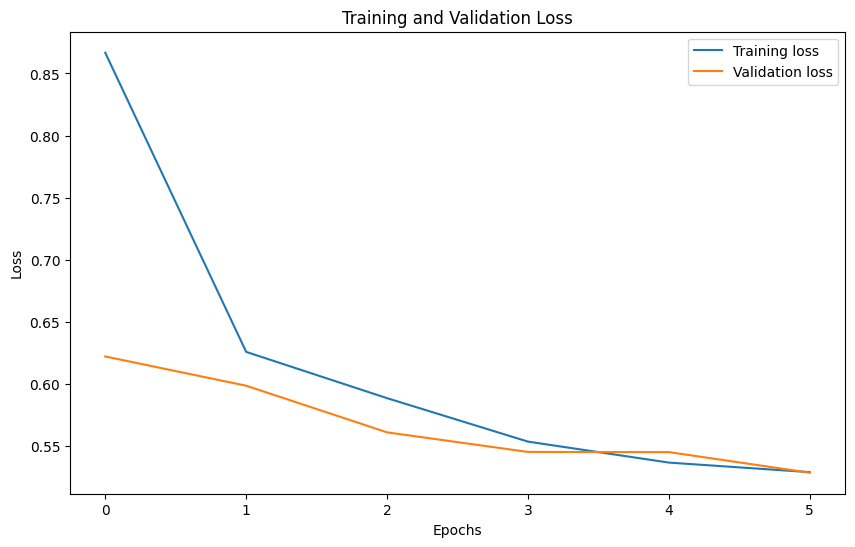

In [231]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Definimos la función encargada de evaluar las métricas en el entrenamiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted') #weighted si desbalanceada
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}



# Definimos los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy='steps',
    eval_steps=93,
    save_strategy='steps',
    save_steps=93,
    logging_strategy='steps',
    logging_dir='./logs',
    logging_steps=93,
    load_best_model_at_end=True,
    seed=42,
)

# Inicializamos el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets['train'],
    eval_dataset=final_datasets['validation'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0)]
)

# Entrenamiento y evaluación
trainer.train()
training_stats = trainer.state.log_history

# Representación de las pérdidas a lo largo de las épocas
training_loss = [e['loss'] for e in training_stats if 'loss' in e]
validation_loss = [e['eval_loss'] for e in training_stats if 'eval_loss' in e]

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()